In [ ]:
"""
1) Check sign of determinant of tetrahedrons
2) Check how assignment of keypoint to left/right affects energy of other keypoints
"""

# Setup

## Imports

In [148]:
"""Normal estimation"""
ROOT_DIR = "/home/user/Documents/projects/Metaworld"

import sys
sys.path.append(ROOT_DIR)

%matplotlib widget  
import argparse
import gc
import os
import json
import random
from PIL import Image
from typing import Dict, List, Union

import cv2
import numpy as np

import gc
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import PILToTensor
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from scipy.spatial.transform import Rotation as R
import importlib
from typing import List
from easydict import EasyDict as edict
from tqdm import tqdm

# visualization
import plotly.express as px
import plotly.graph_objects as go
from lightglue import viz2d
from einops import rearrange

import open3d as o3d
from open3d.web_visualizer import draw

In [149]:
from keyframes.align_ft_spair import dataset
from keyframes.align_ft_spair.utils import geo_utils, spair_utils, ft_align_utils, depth_match_utils, geom_utils, img_utils, kpt_likelihood_utils
from keyframes.align_ft_spair import pl_modules
from keyframes.align_ft_spair.ext import projection_network, utils_correspondence, utils_dataset
from utils import torch_utils, plotly_utils

## Data

In [7]:
# params
spair_data_folder="/media/user/ssd2t/datasets2/SPair-71k"
embds_folder_geo="/media/user/EXTREMESSD/datasets/SPair-71k/geo"
embds_folder_sd="/media/user/EXTREMESSD/datasets/SPair-71k/DiffusionFeatures60x60"
img_files_np_path_train="/home/user/Documents/projects/diffusion-features/experiments/ft_align/aeroplane_train_files_unique.npy"
img_files_np_path_eval="/home/user/Documents/projects/diffusion-features/experiments/ft_align/aeroplane_eval_files_unique.npy"
depth_folder = "/media/user/EXTREMESSD/datasets/SPair-71k/miragold"
# kpt_indices=[3, 4, 5]
category="aeroplane"
img_size=960
embd_size=60
pad=True

img_files_train = np.load(img_files_np_path_train).tolist()
img_files_eval = np.load(img_files_np_path_eval).tolist()

flips_train = [False]
flips_eval = [False]

In [8]:
# load embeddings
img_embds_train, img_embds_hat_train = geo_utils.load_geo_embds(
    img_files_train,
    embds_folder_dino=embds_folder_geo,
    embds_folder_sd=embds_folder_sd,
    flips=flips_train,
)
img_embds_train = img_embds_train.detach().cpu()
img_embds_hat_train = img_embds_hat_train.detach().cpu()

# load embeddings
img_embds_eval, img_embds_hat_eval = geo_utils.load_geo_embds(
    img_files_eval,
    embds_folder_dino=embds_folder_geo,
    embds_folder_sd=embds_folder_sd,
    flips=flips_eval,
)
img_embds_eval = img_embds_eval.detach().cpu()
img_embds_hat_eval = img_embds_hat_eval.detach().cpu()

# build kpt_idx_to_kpt_embds
kpt_idx_to_kpt_embds_train, kpt_embd_coords_train, kpt_img_coords_train = spair_utils.build_kpt_idx_to_kpt_embds(
    img_files=img_files_train,
    img_embds_hat=img_embds_hat_train,
    spair_data_folder=spair_data_folder,
    img_size=img_size,
    embd_size=embd_size,
    pad=pad,
    flips=flips_train
)
kpt_idx_to_kpt_embds_eval, kpt_embd_coords_eval, kpt_img_coords_eval = spair_utils.build_kpt_idx_to_kpt_embds(
    img_files=img_files_eval,
    img_embds_hat=img_embds_hat_eval,
    spair_data_folder=spair_data_folder,
    img_size=img_size,
    embd_size=embd_size,
    pad=pad,
    flips=flips_eval
)

# average keypoint embeddings
kpt_features_avg_train = []
kpt_features_attn_avg_train = []
kpt_features_attn_sd_train = []
for kpt_idx in range(30):
    kpt_features = kpt_idx_to_kpt_embds_train[kpt_idx]
    if kpt_features is not None:
        kpt_features_avg = torch.mean(kpt_features, dim=0, keepdim=True)  # (1, C)
        # compute dot product between kpt_features and kpt_features_avg
        kpt_features_attn = torch.bmm(kpt_features.unsqueeze(0), kpt_features_avg.unsqueeze(2)).squeeze(0)
        kpt_features_attn_avg = torch.mean(kpt_features_attn, dim=0, keepdim=True)
        kpt_features_attn_sd = torch.std(kpt_features_attn, dim=0, keepdim=True)
        kpt_features_avg_train.append(kpt_features_avg)
        kpt_features_attn_avg_train.append(kpt_features_attn_avg)
        kpt_features_attn_sd_train.append(kpt_features_attn_sd)
kpt_features_avg_train = torch.cat(kpt_features_avg_train, dim=0)
kpt_features_attn_avg_train = torch.cat(kpt_features_attn_avg_train, dim=0)
kpt_features_attn_sd_train = torch.cat(kpt_features_attn_sd_train, dim=0)
# print(kpt_features_avg_train.shape)

# 1.1) load depth
depths_train = []
for img_file in img_files_train:
    fn = os.path.basename(img_file).split(".")[0]
    depth_file = f"{depth_folder}/{category}/depth_npy/{fn}_pred.npy"
    depth = np.load(depth_file)
    # NOTE instead of resizing depth we will resize and upscale attentions
    depths_train.append(depth)

depths_eval = []
for img_file in img_files_eval:
    fn = os.path.basename(img_file).split(".")[0]
    depth_file = f"{depth_folder}/{category}/depth_npy/{fn}_pred.npy"
    depth = np.load(depth_file)
    depths_eval.append(depth)

# 1.3) reproject to point clouds
xyz_train = []
for depth in depths_train:
    v0 = geom_utils.reproject_depth(depth)
    xyz_train.append(v0)

xyz_eval = []
for depth in depths_eval:
    v0 = geom_utils.reproject_depth(depth)
    xyz_eval.append(v0)

# TODO save xyz

# px.imshow(depths_padded_resized_train[20])

# Method

In [10]:
# 1) reference geometric relationships of airplane
kpt_xyz_ref_np = kpt_likelihood_utils.load_airplane_kpt_xyz()
kpt_xyz_ref = torch_utils.to_torch(kpt_xyz_ref_np, device="cpu")
kpt_angles_ref, kpt_ratios_ref = kpt_likelihood_utils.compute_angles_and_ratios(kpt_xyz_ref)

In [31]:
importlib.reload(ft_align_utils)

<module 'keyframes.align_ft_spair.utils.ft_align_utils' from '/home/user/Documents/projects/Metaworld/keyframes/align_ft_spair/utils/ft_align_utils.py'>

In [128]:
# 2) for all images in train set extract peaks
n_train_imgs = len(img_embds_train)
peak_kpt_likelihood_all = []
peak_xyz_all = []
peak_concat_indices_all = []
kpt_likelihood_all = []
for img_idx in tqdm(range(n_train_imgs)):
    kpt_likelihood = kpt_likelihood_utils.compute_kpt_likelihood(
        img_embd_hat=img_embds_hat_train[img_idx],
        kpt_embd_hat_mean=kpt_features_avg_train,
        kpt_attn_mean=kpt_features_attn_avg_train[:,0],
        kpt_attn_sd=kpt_features_attn_sd_train[:,0]
    )
    img_xy, img_xyz, K = kpt_likelihood_utils.compute_img_xyz_and_K(
        img_idx=img_idx,
        xyz_train_np=xyz_train,
        embd_size=embd_size,
    )
    img_xyz_orig = torch_utils.to_torch(xyz_train[img_idx], device="cpu")

    # extract peaks for each keypoint
    peak_xyz_coords_all, peak_xy_coords_all, peak_values_all = ft_align_utils.extract_peaks_xyz_for_all_kpts(
        kpt_attn=kpt_likelihood,
        img_xyz_orig=img_xyz_orig,
        max_num_peaks=3,
        min_distance=10,
        min_peak_value=0.01,
    )

    # concatenate all peaks
    peak_xyz_coords_all_concat = torch.cat(peak_xyz_coords_all, dim=0)
    kpt_indices = torch.arange(len(peak_xyz_coords_all))
    peak_concat_indices = [[int(i)]*len(peak_xyz_coords_all[i]) for i in kpt_indices if len(peak_xyz_coords_all[i]) > 0]
    peak_concat_indices = [item for sublist in peak_concat_indices for item in sublist]

    # transform peak img coords to embd coords
    peak_embd_coords_xy = []
    for i in range(len(peak_xy_coords_all)):
        peaks_xy = peak_xy_coords_all[i]
        for p in range(peaks_xy.shape[0]):
            x_new, y_new = spair_utils.transform_image_coords(
                x_orig=peaks_xy[p, 0],
                y_orig=peaks_xy[p,1], 
                img_orig_width=img_xyz_orig.shape[1], 
                img_orig_height=img_xyz_orig.shape[0], 
                img_new_size=embd_size, 
                pad=True
            )
            peak_embd_coords_xy.append([x_new, y_new])
    peak_embd_coords_xy = torch.tensor(peak_embd_coords_xy)



    # create peak_kpt_likelihood and peak_xyz tensor
    if peak_embd_coords_xy.shape[0] > 0:
        peak_kpt_likelihood = kpt_likelihood[:,peak_embd_coords_xy[:,1], peak_embd_coords_xy[:,0]]
        peak_xyz = peak_xyz_coords_all_concat
    else:
        print("No peaks found", img_idx)
        peak_kpt_likelihood = torch.empty((kpt_likelihood.shape[0], 0))
        peak_xyz = torch.empty((0, 3))
    peak_concat_indices_all.append(peak_concat_indices)
    peak_kpt_likelihood_all.append(peak_kpt_likelihood)
    peak_xyz_all.append(peak_xyz)
    kpt_likelihood_all.append(kpt_likelihood)

100%|██████████| 55/55 [00:14<00:00,  3.88it/s]


In [65]:
px.imshow(kpt_likelihood_all[2][0,:,:])

In [130]:
# check whether ground truth keypoint indices are in kpt indices
from sympy import false


for img_idx in range(n_train_imgs):
    ground_truth_indices = set(list(kpt_img_coords_train[img_idx][:,2].numpy()))
    predicted_indices = set(peak_concat_indices_all[img_idx])
    intersection = ground_truth_indices.intersection(predicted_indices)
    do_no_predict_false = {0,1,2,3,22,23,24}
    false_predicted = predicted_indices - intersection
    false_intersection = false_predicted.intersection(do_no_predict_false)
    if len(false_intersection) > 0:
        print("False predicted", img_idx, false_intersection)
    if len(intersection) < len(ground_truth_indices):
        missing = ground_truth_indices - intersection
        false_predicted = predicted_indices - intersection
        print("Ground truth indices not in predicted indices", img_idx, missing, intersection, ground_truth_indices)

False predicted 0 {24}
False predicted 6 {24}
False predicted 8 {2}
False predicted 9 {2}
Ground truth indices not in predicted indices 9 {24} {0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21} {0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24}
False predicted 10 {24}
False predicted 14 {0}
False predicted 15 {2, 3}
False predicted 16 {0, 3}
False predicted 17 {22}
False predicted 18 {1, 2, 22}
False predicted 19 {24}
False predicted 21 {22}
False predicted 24 {1}
False predicted 27 {24}
False predicted 28 {24}
False predicted 29 {1, 2}
False predicted 32 {24}
False predicted 33 {24}
False predicted 34 {0, 2}
False predicted 36 {2}
False predicted 37 {24}
False predicted 39 {24, 3, 22}
False predicted 41 {2}
False predicted 42 {24}
False predicted 43 {23}
False predicted 44 {1, 3}
False predicted 45 {1, 2}
False predicted 46 {3}
False predicted 48 {2, 22}
False predicted 51 {3}
False predicted 53 {3}


In [57]:
set(list(kpt_img_coords_train[0][:,2].numpy()))

{0, 1, 2, 3, 7, 9, 11, 13, 17, 19, 22, 23}

In [59]:
set(peak_concat_indices_all[0])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 21, 22, 23, 24}

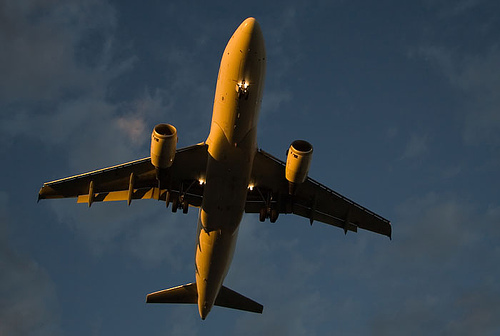

In [141]:
Image.open(img_files_train[9])

In [147]:
px.imshow(kpt_likelihood_all[9][1,:,:])